In [42]:
### Init network Build
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf
%load_ext tensorboard

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

print(tf.__version__, 'tf')
print(keras.__version__, 'keras')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.3.0 tf
2.4.3 keras


In [2]:
df_merged = pd.read_csv('image_metrics_032121_rgb.csv')

In [45]:

data = 'Madhukar/Archived/Dataset_with_merged_SSURGO_NHD_variables/2021.03.09_ssurgo_nhd_merged.csv'
df_nhd_ss = pd.read_csv(data)
data_subset_89='subsets_data/sac_saw_subset_01_89.csv'
df_sac_saw_89 = pd.read_csv(data_subset_89)
df_merged_89 = pd.merge(df_sac_saw_89, df_nhd_ss, left_on = 'da_number', right_on = 'da_number', how = 'left')
#display(df_merged_89)
#X = df_merged_89#.drop(['cwa_determination'], axis=1)
#y = df_merged_89['cwa_determination_x']
from sklearn.model_selection import train_test_split


## adding some filtering for the images that exist.
dir2 = '/data/training_data_rgb3/'
df_image_list = pd.DataFrame({'da_number' : [f.name[:-4] for f in Path(dir2).iterdir()]})
X = pd.merge(df_merged_89, df_image_list, how = 'inner', on = 'da_number')
y = X['cwa_determination_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [46]:
#df_merged = pd.read_csv('image_metrics_032121_rgb.csv')
#X = df_merged
#y = df_merged['cwa_determination']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [47]:
# get list of false negatives.  on both 89 1345
X_test.da_number

224       SAW-2017-00624
42        SAW-2016-00508
285       SAW-2018-02179
302       SAW-2018-00762
56        SAW-2019-00805
             ...        
314       SAC-2017-01409
173       SAW-2018-01569
158       SAW-2020-00905
109    SAC-2015-01563-4S
295       SAW-2015-02071
Name: da_number, Length: 90, dtype: object

In [48]:
#f3 = df_merged.da_num.apply(lambda x: x[:3])
#f3.value_counts()

In [49]:
soi = list(X_train.da_number)
soi_test = list(X_test.da_number)
print(len(soi))
train_X = [f for f in Path(dir2).iterdir() if f.name[:-4] in soi]
test_X = [f for f in Path(dir2).iterdir() if f.name[:-4] in soi_test]

print(len(train_X))

269
269


In [50]:
train_X[0].name[:-4]

'SAW-2017-00318'

In [51]:
np.load(train_X[0]).shape

(3, 256, 256)

In [52]:
def get_label(da_num_i, df_merged = df_merged):
    return int(df_merged[df_merged.da_num == da_num_i].cwa_determination.iloc[0])
get_label(train_X[0].name[:-4])

0

In [53]:
train_y = [get_label(x.name[:-4]) for x in train_X]
test_y = [get_label(x.name[:-4]) for x in test_X]

In [54]:
print(len(train_X), len(train_y))

269 269


In [55]:
arr_train_X = np.array([np.load(f) for f in train_X]).swapaxes(1,3)
arr_test_X = np.array([np.load(f) for f in test_X]).swapaxes(1,3)

arr_train_y = np.array(train_y)
arr_test_y = np.array(test_y)

In [56]:
print(arr_train_X.shape)
print(arr_train_y.shape)
print('number of nans: ', np.sum(np.isnan(arr_train_X)))
print('number of nums: ', np.sum(~np.isnan(arr_train_X)))
arr_train_X = np.nan_to_num(arr_train_X) #convert all nans to zeroes
print('number of nans: ', np.sum(np.isnan(arr_train_X)))
## may need to investigate the nans and figure out some imputation here.

(269, 256, 256, 3)
(269,)
number of nans:  0
number of nums:  52887552
number of nans:  0


In [57]:
print(arr_test_X.shape)
print(arr_test_y.shape)
print('number of nans: ', np.sum(np.isnan(arr_test_X)))
print('number of nums: ', np.sum(~np.isnan(arr_test_X)))
arr_test_X = np.nan_to_num(arr_test_X) #convert all nans to zeroes
print('number of nans: ', np.sum(np.isnan(arr_test_X)))
## may need to investigate the nans and figure out some imputation here.

(90, 256, 256, 3)
(90,)
number of nans:  0
number of nums:  17694720
number of nans:  0


In [58]:
print(np.mean(arr_train_y), 'this is the majority class size.')
print(np.mean(arr_train_X))
print(np.min(arr_train_X))
print(np.max(arr_train_X))

0.17843866171003717 this is the majority class size.
0.4310937314858786
0.0
1.0


In [59]:
np.histogram(arr_train_X[0][:,:,3:])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

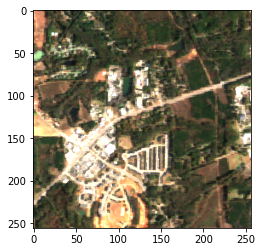

In [60]:
fig, ax = plt.subplots()
ax.imshow(arr_train_X[0])

In [61]:
!nvidia-smi

Thu Mar 25 20:31:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   63C    P0    66W / 149W |  10870MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [62]:
from keras.applications.vgg16 import VGG16

vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model1.trainable = False
vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model2.trainable = False

In [63]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

input_matrix = Input(shape=(256,256,3))   # 6

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)
for i in [0]:
    # create looping so that vgg16 model input is created ie 256,256,3
    print(input_matrix.shape)
    out = Lambda(lambda x: x[:,:,:,i:i+3])(input_matrix)
    print(out.shape)
    
    # Setting up your layers in each branch: (currently each branch is identical architecture.)
    if i == 0: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    elif i == 3: out = Sequential(vgg16_model2)(out)
    else: out = Sequential(vgg16_model3)(out)   # use pretrained and loaded vgg16
    print(out.shape)
#    branch_outputs.append(out)
#mergedOut = Concatenate()(branch_outputs)
mergedOut = out
print(mergedOut.shape)
mergedOut = Dense(512, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.1)(mergedOut)
mergedOut = Dropout(.5)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(256, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.1)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(128, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.1)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(1, activation = 'sigmoid')(mergedOut)

rgb_model_vgg16 = Model(inputs=input_matrix, outputs=mergedOut)   


opt = keras.optimizers.Adam(learning_rate=0.05)

rgb_model_vgg16.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

rgb_model_vgg16.summary()

(None, 256, 256, 3)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 512)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 8, 8, 512)         262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 512)         0         
____________________________________________

In [64]:
opt = keras.optimizers.Adam(learning_rate=0.05)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [65]:
checkpoint_filepath = '/data/model_checkpoints/rgb_89_hi/rgb_89_model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [66]:
t0 = time.time()
history_callback = rgb_model_vgg16.fit(arr_train_X, arr_train_y, epochs=30, 
                                       batch_size=128, validation_split = 0.2, 
                                       workers=4, use_multiprocessing=True,
                                       callbacks = [model_checkpoint_callback])
print("Train time:", time.time()-t0)

Epoch 1/30
2/2 [==============================] - 33s 16s/step - loss: 1.2277 - accuracy: 0.5488 - val_loss: 122.0074 - val_accuracy: 0.1852
Epoch 2/30
2/2 [==============================] - 2s 916ms/step - loss: 2.8284 - accuracy: 0.7349 - val_loss: 73.9820 - val_accuracy: 0.8148
Epoch 3/30
2/2 [==============================] - 2s 905ms/step - loss: 1.3930 - accuracy: 0.8977 - val_loss: 107.2370 - val_accuracy: 0.8519
Epoch 4/30
2/2 [==============================] - 1s 698ms/step - loss: 0.9986 - accuracy: 0.9070 - val_loss: 268.9571 - val_accuracy: 0.3704
Epoch 5/30
2/2 [==============================] - 1s 701ms/step - loss: 1.2765 - accuracy: 0.8884 - val_loss: 386.0322 - val_accuracy: 0.3333
Epoch 6/30
2/2 [==============================] - 1s 706ms/step - loss: 1.0217 - accuracy: 0.9070 - val_loss: 132.4441 - val_accuracy: 0.7778
Epoch 7/30
2/2 [==============================] - 1s 701ms/step - loss: 0.9554 - accuracy: 0.9116 - val_loss: 186.0705 - val_accuracy: 0.6111
Epoch 8/

In [67]:
run1 = history_callback.history
#run1


In [68]:
#model_out.save('/data/model_saves/89_model') 89 model saved mar 18

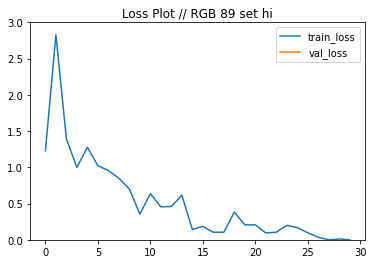

In [69]:
train_loss = run1['loss']
val_loss = run1['val_loss']
x = np.arange(len(train_loss))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, train_loss, label='train_loss')
ax.plot(x, val_loss, label='val_loss')
ax.set_ylim(0, 3) 
plt.title('Loss Plot // RGB 89 set hi')
ax.legend()
plt.show()

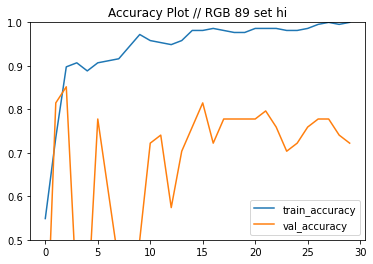

In [70]:
train_accuracy = run1['accuracy']
val_accuracy = run1['val_accuracy']
x = np.arange(len(train_accuracy))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, train_accuracy, label='train_accuracy')
ax.plot(x, val_accuracy, label='val_accuracy')
ax.set_ylim(0.5, 1) 
plt.title('Accuracy Plot // RGB 89 set hi')
ax.legend()
plt.show()

In [71]:
np.mean(arr_train_y)

0.17843866171003717

In [72]:
np.mean(arr_test_y)

0.28888888888888886

In [74]:
#reload best model
from keras.models import load_model

best_model = rgb_model_vgg16.load_weights('/data/model_checkpoints/rgb_1235_hi/rgb_1235_model.20-0.86.h5')

In [75]:
test_preds = rgb_model_vgg16.predict(arr_test_X, batch_size = 128)
print(test_preds[:8])

KeyboardInterrupt: 

In [ ]:
#print(len(rounded_preds))
rounded_preds = np.round(test_preds)
rounded_preds[:8]

In [ ]:
da_n = [x.name[:-4] for x in test_X]
df_pred = pd.DataFrame({'da_number' : da_n, 'predicted' : list(rounded_preds), 'cwa_determination' : test_y})
df_pred.predicted = df_pred.predicted.apply(int)
print(df_pred.dtypes)
display(df_pred.head(10))
df_pred.to_csv('/data/model_checkpoints/rgb_89_hi/rgb_preds_89_hi.csv')
df_pred[(df_pred.predicted == 0)&(df_pred.cwa_determination == 1)]
false_neg = df_pred[(df_pred.predicted == 0)&(df_pred.cwa_determination == 1)].shape[0]
false_pos = df_pred[(df_pred.predicted == 1)&(df_pred.cwa_determination == 0)].shape[0]
true_pos = df_pred[(df_pred.predicted == 1)&(df_pred.cwa_determination == 1)].shape[0]
true_neg = df_pred[(df_pred.predicted == 0)&(df_pred.cwa_determination == 0)].shape[0]
print('false_neg:', false_neg)
print('false_pos:', false_pos)
print('true_pos:', true_pos)
print('true_neg:', true_neg)